# Exploratory Data Analysis of Weather in Illinois

In [1]:
import pandas as pd # DataFrame library
import numpy as np # Array library
import matplotlib.pyplot as plt # Plotting library
import folium

### The data was extracted from the NOAA's Global Historical Climatology Network (GHCN) dataset. The SQL query was run in the Google BigQuery console as shown below. The resulting dataset was saved to a dataframe as shown in the next cell.

![Illinois Temperature Data (1990 - 2023).png](<attachment:Illinois Temperature Data (1990 - 2023).png>)

### To save on time and prevent potential costly charges, the queried result was downloaded as a parquet file. It is possible to insert the queried result directly to a pandas DataFrame as shown in the code block below. Here's an example for querying just the temperature variables.

```python
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./secrets/my_credentials.json" # Credentials to be able to access the Google BigQuery public datasets
```

```python
raw_weather_query = """SELECT weather.id, weather.date, weather.element, weather.value, weather.qflag, 
                       stations.latitude, stations.longitude, stations.state, stations.name 
                       FROM `bigquery-public-data.ghcn_d.ghcnd_*` AS weather
                       INNER JOIN `bigquery-public-data.ghcn_d.ghcnd_stations` AS stations
                       ON weather.id = stations.id
                       WHERE weather.id LIKE 'US%'
                       AND weather.element IN ('TMAX', 'TMIN', 'TAVG', 'TOBS')
                       AND weather.qflag IS NULL
                       AND EXTRACT(YEAR FROM weather.date) BETWEEN 1990 AND 2023
                       AND weather._TABLE_SUFFIX BETWEEN '1990' AND '2023'
                       AND stations.id LIKE 'US%'
                       AND stations.state = 'IL'; """ # This query extracts weather data from the US in Illinois from the year 1990 to 2023
raw_weather_data = pd.read_gbq(raw_weather_query, use_bqstorage_api = True, progress_bar_type = "tqdm_notebook", dialect = "standard") # Load the data from the SQL query through Google BigQuery
```

### The cell below loads a subset of the data that's needed for analysis along with some modifications to the "time" column.

In [2]:
desired_cols = ["date", "time", "name", "element", "value", "latitude", "longitude"] # columns that are going to be used for analysis
desired_types = {"date": "string", "time": "string", "name": "string", 
              "element": "string", "value": "float", "latitude": "float", 
              "longitude": "float"} # the data types that will be assigned per column
raw_weather = pd.read_parquet("illinois_weather_data.parquet", columns = desired_cols) # Load in the Illinois weather data from the parquet file
raw_weather["time"].fillna("0000", inplace = True) # replace all nan values with "0000"
raw_weather = raw_weather.astype(desired_types) # assign the appropriate data types for each column
raw_weather["time"] = raw_weather["time"].apply(lambda x: x[:-2]) # drops the period and zero at the end (i.e. 1310.0 will become 1310)

/var/folders/j5/byfswq3j1bg3s3yk6x9qdzbr0000gp/T/ipykernel_2895/3416009114.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0000' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  raw_weather["time"].fillna("0000", inplace = True) # replace all nan values with "0000"


In [3]:
np.sort(raw_weather["time"].apply(len).unique()) # helps to verify how many unique length characters there was in the "time" column. 
# there should only be one of length 4 characters to be able to parse into datetime format.

array([1, 2, 3, 4])

### The function below fixes the length of the time values which are in string form so that they have a fixed length of 4 characters.

In [4]:
def fix_char_length(val):
    if len(val) == 1:
        return "0" + val + "00"
    elif len(val) == 2:
        return "00" + val
    elif len(val) == 3:
        return "0" + val
    else:
        return val

In [5]:
raw_weather["time"] = raw_weather["time"].apply(fix_char_length) # fixes the character lengths so that they are at least 4 characters long
raw_weather["time"] = raw_weather["time"].apply(lambda x: f"{x[:-2]}:{x[-2:]}:00") # added columns and a seconds placeholder for parsing
raw_weather["time"] = pd.to_timedelta(raw_weather["time"]) # converts string format to datetime format

In [6]:
raw_weather["date"] = pd.to_datetime(raw_weather["date"]) # converts the string format to a datetime format
raw_weather["date"] = raw_weather["date"] + raw_weather["time"] # combines date and time into the same column which can be accessed via object attributes
raw_weather.drop(columns = ["time"], inplace = True) # drops the redundant time column
raw_weather

,date,name,element,value,latitude,longitude
0,2006-05-20 08:00:00,CONGERVILLE 2NW,PRCP,0.0,40.6211,-89.2414
1,2006-05-12 06:00:00,PRAIRIE CITY 2S,PRCP,0.0,40.5914,-90.4642
2,2006-04-11 07:00:00,ST CHARLES 7 NW,PRCP,0.0,41.9603,-88.4228
3,2006-12-06 00:00:00,ROCKFORD GTR ROCKFORD AP,PRCP,3.0,42.1933,-89.0933
4,2006-10-22 07:00:00,LEBANON,PRCP,8.0,38.6003,-89.8178
...,...,...,...,...,...,...
16618313,2021-10-29 07:00:00,RAMSEY,TOBS,111.0,39.1481,-89.1022
16618314,2021-02-18 07:00:00,IUKA 12 SW,TOBS,-117.0,38.4933,-88.9708
16618315,2021-02-19 06:30:00,PAXTON 2 WSW,TOBS,-172.0,40.4550,-88.1417
16618316,2021-02-27 07:00:00,SIDELL 4N,TOBS,11.0,39.9678,-87.8228


### The cell below pivots the element values into columns which are more useful in column format.

In [7]:
raw_weather_pivot = raw_weather.pivot(columns = "element", values = "value") # converts the categorical data in the elements column to their own respective columns
raw_weather_pivot

element,PRCP,PSUN,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS,TSUN
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
16618313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111.0,NaN
16618314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-117.0,NaN
16618315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-172.0,NaN
16618316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN


In [8]:
transformed_data = pd.concat([raw_weather, raw_weather_pivot], axis = 1) # combine the newly generated columns with the existing dataframe
transformed_data.drop(columns = ["element", "value"], inplace = True) # drop the element and value columns
transformed_data["TMIN"] = 9/5 * (transformed_data["TMIN"] / 10) + 32 # converting from tenths of a degree Celsius to Fahrenheit
transformed_data["TMAX"] = 9/5 * (transformed_data["TMAX"] / 10) + 32 
transformed_data["TAVG"] = 9/5 * (transformed_data["TAVG"] / 10) + 32
transformed_data["TOBS"] = 9/5 * (transformed_data["TOBS"] / 10) + 32
transformed_data["PRCP"] = transformed_data["PRCP"] / 10 * 25.4 # converting tenths of a millimeter to inches
transformed_data["SNOW"] = transformed_data["SNOW"] * 25.4 # converting millimeters to inches
transformed_data["SNWD"] = transformed_data["SNWD"] * 25.4
transformed_data

,date,name,latitude,longitude,PRCP,PSUN,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS,TSUN
0,2006-05-20 08:00:00,CONGERVILLE 2NW,40.6211,-89.2414,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-05-12 06:00:00,PRAIRIE CITY 2S,40.5914,-90.4642,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-04-11 07:00:00,ST CHARLES 7 NW,41.9603,-88.4228,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-12-06 00:00:00,ROCKFORD GTR ROCKFORD AP,42.1933,-89.0933,7.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006-10-22 07:00:00,LEBANON,38.6003,-89.8178,20.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16618313,2021-10-29 07:00:00,RAMSEY,39.1481,-89.1022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.98,NaN
16618314,2021-02-18 07:00:00,IUKA 12 SW,38.4933,-88.9708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.94,NaN
16618315,2021-02-19 06:30:00,PAXTON 2 WSW,40.4550,-88.1417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.04,NaN
16618316,2021-02-27 07:00:00,SIDELL 4N,39.9678,-87.8228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.98,NaN


### This cell below plots the minimum, maximum, and observed temperatures.

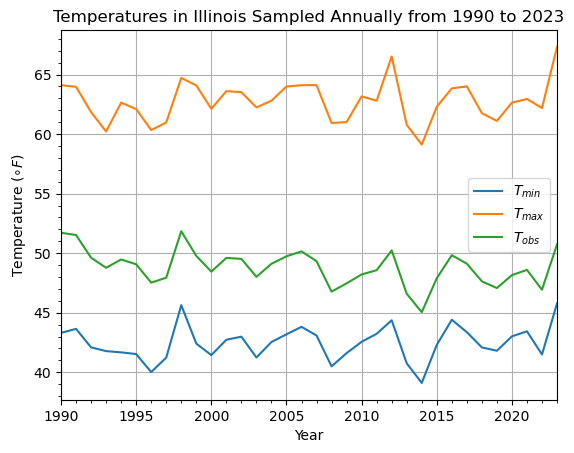

In [45]:
# Resample the temperature data annually and calculate the mean
numeric_data = transformed_data.select_dtypes(include = ["datetime64[ns]", "float"])
resampled_data = numeric_data.resample("Y", on="date").mean()
tmin_label = r"$T_{min}$"
tmax_label = r"$T_{max}$"
tobs_label = r"$T_{obs}$"

# Plotting TMIN, TMAX, and TOBS
plt.plot(resampled_data.index.year, resampled_data["TMIN"], label= tmin_label)
plt.plot(resampled_data.index.year, resampled_data["TMAX"], label= tmax_label)
plt.plot(resampled_data.index.year, resampled_data["TOBS"], label= tobs_label)

# Set labels and title
plt.xlabel("Year")
plt.ylabel(r"Temperature ($\circ F$)")
plt.title("Temperatures in Illinois Sampled Annually from 1990 to 2023")

# Display the legend
plt.legend(loc="best")

# Fixes the x-range so that it's between 1990 and 2023
plt.xlim(resampled_data.index.year.min(), resampled_data.index.year.max())

# Display the grid
plt.grid()

# Display minor ticks
plt.minorticks_on()

# Show the plot
plt.show()

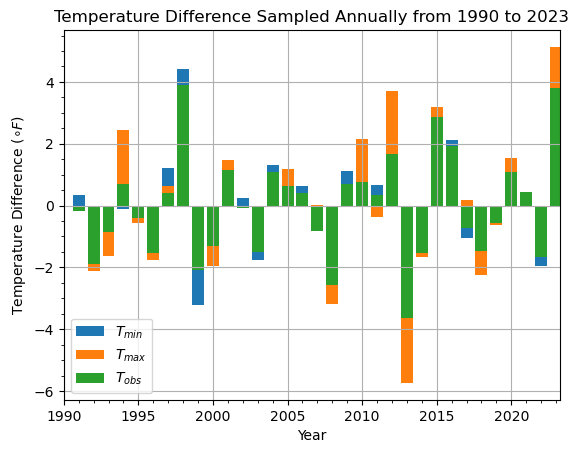

In [50]:
# Plotting the temperature gradient (difference) for TMIN, TMAX, TOBS
plt.bar(resampled_data.index.year, resampled_data["TMIN"].diff(), label = tmin_label)
plt.bar(resampled_data.index.year, resampled_data["TMAX"].diff(), label = tmax_label)
plt.bar(resampled_data.index.year, resampled_data["TOBS"].diff(), label = tobs_label)

# Adding labels
plt.xlabel("Year")
plt.ylabel(r"Temperature Difference ($\circ F$)")

# Display a legend
plt.legend(loc = "lower left")

# Fix the x-range so that all the bars for each year display properly
plt.xlim(resampled_data.index.year.min(), resampled_data.index.year.max() + 0.25)

# Adding a title
plt.title("Temperature Difference Sampled Annually from 1990 to 2023")

# Display grid and minor ticks
plt.grid()
plt.minorticks_on()

# Show the plot
plt.show()

In [19]:
transformed_data["name"].nunique() # number of stations in Illinois

1912

In [20]:
num_obs_per_station = transformed_data.groupby("name", as_index = False)["date"].count() # number of observations per station
num_obs_per_station.rename(columns = {"date": "obs_count"}, inplace = True)
num_obs_per_station

,name,obs_count
0,ADDIEVILLE 5.7 SW,350
1,ADDISON 1.6 WNW,362
2,ALBERS 1 W,24134
3,ALBION,31578
4,ALBION 0.2 SW,2746
...,...,...
1907,YORKVILLE 2.8 NE,1322
1908,YORKVILLE 2.8 SSW,175
1909,YORKVILLE 2SE,11815
1910,YORKVILLE 3.1 N,263


In [21]:
num_obs_per_station.min() # Station with the least number of observations

/var/folders/j5/byfswq3j1bg3s3yk6x9qdzbr0000gp/T/ipykernel_2895/2149998279.py:1: FutureWarning: <class 'pandas.core.arrays.string_.StringArray'>._reduce will require a `keepdims` parameter in the future
  num_obs_per_station.min() # Station with the least number of observations


name         ADDIEVILLE 5.7 SW
obs_count                    1
dtype: object

In [22]:
num_obs_per_station.max() # Station with the most number of observations

/var/folders/j5/byfswq3j1bg3s3yk6x9qdzbr0000gp/T/ipykernel_2895/230173862.py:1: FutureWarning: <class 'pandas.core.arrays.string_.StringArray'>._reduce will require a `keepdims` parameter in the future
  num_obs_per_station.max() # Station with the most number of observations


name         ZION 0.5 WNW
obs_count           73973
dtype: object

In [51]:
# Create a base map
m = folium.Map(location=[resampled_data['latitude'], resampled_data['longitude']], zoom_start=5)

# Add markers for each data point
for index, row in resampled_data.iterrows():
    folium.Marker([row['latitude'], row['longitude']], 
                  popup=f'Temperature: {row["TOBS"]}°F').add_to(m)
    
m

ValueError: Location should consist of two numerical values, but date
1990-12-31    40.087956
1991-12-31    40.085110
1992-12-31    40.092840
1993-12-31    40.115903
1994-12-31    40.125628
1995-12-31    40.121197
1996-12-31    40.120038
1997-12-31    40.132565
1998-12-31    40.117600
1999-12-31    40.147345
2000-12-31    40.184618
2001-12-31    40.195606
2002-12-31    40.183330
2003-12-31    40.205681
2004-12-31    40.179216
2005-12-31    40.167685
2006-12-31    40.171692
2007-12-31    40.354789
2008-12-31    40.453184
2009-12-31    40.426641
2010-12-31    40.451422
2011-12-31    40.566821
2012-12-31    40.634451
2013-12-31    40.640652
2014-12-31    40.657526
2015-12-31    40.669414
2016-12-31    40.640628
2017-12-31    40.610552
2018-12-31    40.619903
2019-12-31    40.591557
2020-12-31    40.626097
2021-12-31    40.609523
2022-12-31    40.580099
2023-12-31    40.574375
Freq: A-DEC, Name: latitude, dtype: float64 of type <class 'pandas.core.series.Series'> is not convertible to float.